In [1]:
%load_ext autoreload
%autoreload 2
import sys
import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D
sys.path.insert(0, "../scripts/")
from load_encoder_decoder import build_encoder_decoder_from_vgg
from data_generator import DataGenerator
from losses import overall_loss_wrapper, sad_wrapper, mse_wrapper
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
PATIENCE=30
PATH_MODEL_CHECKPOINTS = "../model_checkpoints/"
PATH_LOGS = "../logs/"
BACKGROUNDS_PER_FG_TRAIN = 100
BACKGROUNDS_PER_FG_TEST = 20
BATCH_SIZE=16

In [3]:
inputs, model = build_encoder_decoder_from_vgg()

In [3]:
fg_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_foregrounds\\"
bg_train = "D:\\Image Matting Dataset\\mscoco\\train2014\\train2014\\"
a_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_alphas\\"

fg_names_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\training_fg_names.txt"
bg_names_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\training_bg_names.txt"

combined_train = "D:\\Image Matting Dataset\\merged_dataset\\"


fg_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\fg\\"
bg_test = "D:\\Image Matting Dataset\\mscoco\\test_selected\\"
a_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\alpha\\"

fg_names_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_fg_names.txt"
bg_names_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_bg_names.txt"

combined_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds_pascal_bg"

# test_gen = DataGenerator(path_combined_test, path_alphas_test, 16, False) 
train_gen = DataGenerator(fg_names_train, bg_names_train, BACKGROUNDS_PER_FG_TRAIN, fg_train, bg_train, a_train,  combined_train, BATCH_SIZE, False)
test_gen = DataGenerator(fg_names_test, bg_names_test, BACKGROUNDS_PER_FG_TEST, fg_test, bg_test, a_test, combined_test, BATCH_SIZE, False)

['035A4301.jpg', '035A4302.jpg', '035A4304.jpg', '035A4305.jpg', '035A4308.jpg', '035A4310.jpg', '035A4311.jpg', '035A4313.jpg', '035A4316.jpg', '035A4320.jpg']
['16452523375_08591714cf_o.png', 'antique-honiton-lace-1182740_1920.png', 'ball-597523_1920.png', 'beach-747750_1280.png', 'boy-1518482_1920.png', 'brandy-402572_1920.png', 'cat-1288531_1920.png', 'cobweb-morgentau-dew-dewdrop-52501.png', 'crystal-82296_1920.png', 'dandelion-1335575_1920.png']


In [4]:
from PIL import Image
import numpy as np
from trimap import generate_trimap
import cv2 as cv

In [106]:
%prun x = np.array(Image.open(fg_train + '035A4301.jpg'))

In [107]:
np.array(x).shape

(1067, 1600, 3)

In [108]:
z = cv.imread(fg_train + '035A4301.jpg')

In [104]:
z.shape

(1067, 1600, 3)

In [93]:
%prun x = np.array(cv.imread(fg_train + '035A4301.jpg'))

In [84]:
import time
start = time.time()
generate_trimap(x)
print(time.time() - start)

0.26383423805236816


In [11]:
# import time
# start = time.time()
%prun train_gen[15]
# print(time.time() - start)

In [136]:
k = train_gen[12]

In [121]:
from matplotlib.pyplot import imshow


In [137]:
k[2][0][2].shape

(1600, 1133, 3)

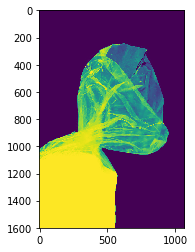

In [141]:
imshow(k[2][0][3])

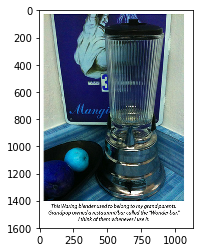

In [138]:
imshow(k[2][0][2])

In [5]:
tensor_board = keras.callbacks.TensorBoard(log_dir=PATH_LOGS, histogram_freq=0, write_graph=True, write_images=True)
model_name = PATH_MODEL_CHECKPOINTS + 'encoder_decoder.{epoch:02d}-val_loss-{val_loss:.4f}-val_sad-{val_sad:.4f}-val_mse-{val_mse:.4f}.hdf5'
model_checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_loss', patience=PATIENCE, verbose=1)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=PATIENCE // 4, verbose=1)

callbacks = [tensor_board, model_checkpoint, early_stop, reduce_lr]

In [14]:
model.compile(optimizer="adam", loss=overall_loss_wrapper(inputs), metrics=[sad_wrapper(inputs), mse_wrapper(inputs)])

In [55]:
history = model.fit_generator(train_gen, validation_data=test_gen, use_multiprocessing=False, workers=1, callbacks=callbacks, shuffle=False, epochs=1, validation_steps=2, steps_per_epoch=2)

Epoch 1/1
2/2 [==============================] - 45s 23s/step - loss: 0.2821 - sad: 32.6476 - mse: 0.0970 - val_loss: 0.4163 - val_sad: 49.0796 - val_mse: 0.2269

Epoch 00001: val_loss improved from inf to 0.41632, saving model to ../model_checkpoints/encoder_decoder.01-0.4163-49.0796-0.2269.hdf5
